In [9]:
import numpy as np
from sedpy.observate import load_filters
from sedpy.observate import Filter
from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import matplotlib.pyplot as plt
from astropy import units as u
import pandas as pd


In [2]:
import fsps

ImportError: dynamic module does not define module export function (PyInit__fsps)

In [31]:
def lognormal_sfh(total_mass, tau, t0, times):
        #t0_yr = t0*1e9
        t = times
        sfr = []
        for time in t:
            time_yr = time*1e9
            now = total_mass * ((1./np.sqrt(2.*np.pi*tau**2))*(1./time_yr)
                     * np.exp(-(np.log(time) - t0)**2/(2*tau**2)))
            #print(now)
            sfr.append(now)
        return sfr


/Users/sidneylower/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


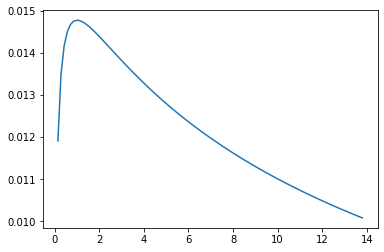

In [51]:
plt.plot(times, sfh)

In [10]:
run_params = {'verbose':False,
              'debug':False,
              'output_pickles': False,
              # dynesty Fitter parameters
              'nested_bound': 'multi', # bounding method
              'nested_sample': 'auto', # sampling method
              'nested_nlive_init': 300,
              'nested_nlive_batch': 300,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              }

In [109]:
# --------------
# Model Definition
# --------------

def build_model(**kwargs):
    """Construct a model.  This method defines a number of parameter
    specification dictionaries and uses them to initialize a
    `models.sedmodel.SedModel` object.
    :param object_redshift:
        If given, given the model redshift to this value.
    :param add_dust: (optional, default: False)
        Switch to add (fixed) parameters relevant for dust emission.
    :param add_neb: (optional, default: False)
        Switch to add (fixed) parameters relevant for nebular emission, and
        turn nebular emission on.
    :param luminosity_distance: (optional)
        If present, add a `"lumdist"` parameter to the model, and set it's
        value (in Mpc) to this.  This allows one to decouple redshift from
        distance, and fit, e.g., absolute magnitudes (by setting
        luminosity_distance to 1e-5 (10pc))
    """
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel

    # --- Get a basic delay-tau SFH parameter set. ---
    # This has 5 free parameters:
    #   "mass", "logzsol", "dust2", "tage", "tau"
    # And two fixed parameters
    #   "zred"=0.1, "sfh"=4
    # See the python-FSPS documentation for details about most of these
    # parameters.  Also, look at `TemplateLibrary.describe("parametric_sfh")` to
    # view the parameters, their initial values, and the priors in detail.
    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    model_params['tau']['isfree'] = False
    model_params['tau']['init'] = 1.0
    model_params['sf_start'] = {"N": 1, "isfree": False,
                           "init": 1.0, 
                            "units": "start of SF, Gyr"}


    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=1.0, maxi=10.0)
    model_params['tage']['init'] = 5.0
    model_params['logzsol']['init'] = 0.2
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.ClippedNormal(mini=-1.5, maxi=0.5, mean=0.0, sigma=0.3)                                                                                                                                                                  
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    # Set the dust and agn emission free                                                                                                                                                                                                      
                                                                                                                                                                                                 
    model_params['duste_gamma']['init'] = 0.01
    model_params['duste_qpah']['init'] = 3.5
    model_params['duste_umin']['init'] = 1.0                                                                                                                                                                

    
    model_params = model_library(model_params, 'MW', False)

    # Now instantiate the model using this new dictionary of parameter specifications
    model = sedmodel.SedModel(model_params)
    

    return model

In [211]:
'''
Attenuation model bank


model_params["dust_type"] = {"N": 1, "isfree": False, "init": 1, "units": "FSPS index"} #MW                                                                                                                                              \
model_params["mrw"] = {"N": 1, "isfree": True,
                           "init": 1.0, "units": "The ratio of total to selective absorption which characterizes the MW extinction curve", 'prior' : priors.TopHat(mini=2.0, maxi=5.0)}
model_params['uvb'] = {'N': 1, 'isfree': True,
                           'init': 1.0, 'units':"characterizing the strength of the 2175A extinction feature with respect to the standard Cardelli et al. determination for the MW",
                           'prior': priors.TopHat(mini = 0.1, maxi=3.0)}





model_params["dust_type"] = {"N": 1, "isfree": False, "init": 2, "units": "FSPS index"} #Calzetti                                                                                                                                         
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"] = {"N": 1, "isfree": False,
                         "init": 0.0, "units": "optical depth towards young stars"}



model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"} #Conroy & Kriek dust atten.                                                                                                                      \
                                                                                                                                                                                                                                              
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "optical depth towards young stars",
                     "prior": priors.TopHat(mini=0.0, maxi=2.0)}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.5, maxi=0.7)}



model_params["dust_type"] = {"N": 1, "isfree": False, "init": 0, "units": "FSPS index"} #power-law                                                                                                                                       \
                                                                                                                                                                                                                                              

model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
model_params["dust1"]  = {"N": 1, "isfree": True,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
model_params["dust_index1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}

'''


'\nAttenuation model bank\n\n\nmodel_params["dust_type"] = {"N": 1, "isfree": False, "init": 1, "units": "FSPS index"} #MW                                                                                                                                              model_params["mrw"] = {"N": 1, "isfree": True,\n                           "init": 1.0, "units": "The ratio of total to selective absorption which characterizes the MW extinction curve", \'prior\' : priors.TopHat(mini=2.0, maxi=5.0)}\nmodel_params[\'uvb\'] = {\'N\': 1, \'isfree\': True,\n                           \'init\': 1.0, \'units\':"characterizing the strength of the 2175A extinction feature with respect to the standard Cardelli et al. determination for the MW",\n                           \'prior\': priors.TopHat(mini = 0.1, maxi=3.0)}\n\n\n\n\n\nmodel_params["dust_type"] = {"N": 1, "isfree": False, "init": 2, "units": "FSPS index"} #Calzetti                                                                              

In [ ]:
def load_obs(sed_file = run_params['sed_file'],  **kwargs):

    from hyperion.model import ModelOutput
    from astropy.cosmology import Planck15
    from astropy import units as u
    from astropy import constants
    m = ModelOutput(sed_file)

    wav,flux = m.get_sed(inclination='all',aperture=-1)
    wav  = np.asarray(wav)*u.micron #wav is in micron                                                                                                                             
    z = 0.01
    wav = wav.to(u.AA)
    wav *= (1.+z)
    flux = np.asarray(flux)*u.erg/u.s
    dl = Planck15.luminosity_distance(z)
    dl = dl.to(u.cm)
    flux /= (4.*3.14*dl**2.)
    nu = constants.c.cgs/(wav.to(u.cm))
    nu = nu.to(u.Hz)

    flux /= nu
    flux = flux.to(u.Jy)
    maggies = flux[0] / 3631.


    filters = load_filters(filternames)
    filter_wavs = [x.wave_mean for x in filters]
    filter_width = [x.effective_width for x in filters]
    flx = []
    flxe = []
    for i in range(len(filters)):
        if filter_wavs[i] < 1e5:
            left = obs_spec[np.abs(obs_wav - (filter_wavs[i] - filter_width[i])).argmin()]
            right = obs_spec[np.abs(obs_wav - (filter_wavs[i] + filter_width[i])).argmin()]
            ave = np.average([left, right])
            flx.append(ave)
        else:
            left = obs_spec[np.abs(obs_wav - (filter_wavs[i] - 0)).argmin()]
            flx.append(left)
        flxe.append(0.01* flx[i])
    flx = np.asarray(flx)
    flxe = np.asarray(flxe)


    flux_mag = flx
    unc_mag = flxe
    obs = {}
    obs['filters'] = filters
    # This is a list of maggies, converted from mJy.  It should have the same                                                                                                     
    # order as `filters` above.                                                                                                                                                   
    obs['maggies'] = flux_mag
    #Uncertainties also converted from mJy. In same order as flux_mag and filters                                                                                                 
    obs['maggies_unc'] = unc_mag
    # Here we mask out any NaNs or infs                                                                                                                                           
    obs['phot_mask'] = np.isfinite(flux_mag)
    # We have no spectrum.                                                                                                                                                        
    obs['wavelength'] = None
    obs['spectrum'] = None
    return obs

In [4]:
# --------------                                                                                                                                                                                                                              
# OBS                                                                                                                                                                                                                                         
# --------------                                                                                                                                                                                                                              

# Here we are going to put together some filter names                                                                                                                                                                                         
galex = ['galex_FUV']
hst_wfc3_uv  = ['wfc3_uvis_f336w', 'wfc3_uvis_f475w','wfc3_uvis_f555w',  'wfc3_uvis_f814w']
#sdss = ['sdss_i0']                                                                                                                                                                                                                           
hst_wfc3_ir = ['wfc3_ir_f125w', 'wfc3_ir_f160w']
#spitzer_mips = ['spitzer_mips_24']                                                                                                                                                                                                           
#wise = ['wise_w4']                                                                                                                                                                                                                           
irac = ['spitzer_irac_ch1']
herschel_pacs = ['herschel_pacs_70', 'herschel_pacs_100', 'herschel_pacs_160']
herschel_spire = ['herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500']




# All these filters are available in sedpy.  If you want to use other filters,                                                                                                                                                                
# add their transmission profiles to sedpy/sedpy/data/filters/ with appropriate                                                                                                                                                               
# names (and format)                                                                                                                                                                                                                          
filternames = (galex + hst_wfc3_uv + hst_wfc3_ir + irac + herschel_pacs + herschel_spire)

In [110]:
def build_obs(**kwargs):
    sps = build_sps()
    mod = build_model()
    fake_obs = {'filters': load_filters(filternames), 'wavelength': None}

    # Change all of your model parameters for testing here
    mod.params['dust_type'] = 0 # non-Calzetti attenuation curve
    #mod.params['dust1'] = 1.0
    # Create your desired input free parameters here
    initial_theta = mod.initial_theta.copy()
    
    
    initial_theta[mod.theta_labels().index('dust2')] = 1.5 # more dust
    initial_theta[mod.theta_labels().index('logzsol')] = 0.0
    initial_theta[mod.theta_labels().index('tage')] = 2.0
    spec, mags, stellar_mass = mod.mean_model(initial_theta,sps=sps,obs=fake_obs)
    #print(mod.theta_labels(), initial_theta)
    obs = {}
    obs['maggies'] = mags  
    obs['filters'] = load_filters(filternames)                                                                                                                                                             
    obs['maggies_unc'] = mags * 0.01                                                                                                                                                                                                    
    obs['phot_mask'] = np.isfinite(mags)                                                                                                                                                                                                                   
    obs['wavelength'] = None
    
    return obs

In [111]:
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps

In [112]:
def build_noise(**extras):
    return None, None

In [113]:
def build_all(**kwargs):

    return (build_obs(**kwargs), build_model(**kwargs),
            build_sps(**kwargs), build_noise(**kwargs))

In [114]:
obs, model, sps, noise = build_all(**run_params)

In [123]:
model.init_config['dust_type']['units']

'MW'

In [108]:
def model_library(model_params, attenuation_model, dust1=False):
    #print(model_params)
    #print(attenuation_model)
    if attenuation_model == 0 or 'MW' or 'Cardelli' or 'cardelli':
        name = 'MW'
        model_params["dust_type"] = {"N": 1, "isfree": False, "init": 1, "units": name} #MW                                                                                                                                              \
        model_params["mrw"] = {"N": 1, "isfree": True,
                           "init": 1.0, "units": "The ratio of total to selective absorption which characterizes the MW extinction curve", 'prior' : priors.TopHat(mini=2.0, maxi=5.0)}
        model_params['uvb'] = {'N': 1, 'isfree': True,
                           'init': 1.0, 'units':"characterizing the strength of the 2175A extinction feature with respect to the standard Cardelli et al. determination for the MW",
                           'prior': priors.TopHat(mini = 0.1, maxi=3.0)}
    elif attenuation_model == 1 or 'power law' or 'powerlaw':
        name = 'PL'
        model_params["dust_type"] = {"N": 1, "isfree": False, "init": 0, "units": "FSPS index"} #power-law                              
        model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
        model_params["dust1"]  = {"N": 1, "isfree": dust1,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}
        model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": -0.7, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
        model_params["dust_index1"] = {"N": 1, "isfree": True,
                     "init": -1.0, "units": "power-law multiplication of Calzetti",
                                       "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
        
      
    return model_params

In [14]:
import time, sys
obs, model, sps, noise = build_all(**run_params)
name = model.init_config['dust_type']['units']
run_params["sps_libraries"] = sps.ssp.libraries
#run_params["param_file"] = __file__

#print(model)

#if args.debug:
#    sys.exit()

#hfile = setup_h5(model=model, obs=obs, **run_params)
hfile = "/Users/sidneylower/Documents/attenuation_runs/inputPL_modelPL.h5"
output = fit_model(obs, model, sps, noise, **run_params)

writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

try:
    hfile.close()
except(AttributeError):
    pass

iter: 11230 | batch: 1 | nc: 1 | ncall: 47594 | eff(%): 23.505 | loglstar: -255.140 < -251.762 < -253.101 | logz: -280.743 +/-  0.423 | stop:  1.186     /Users/sidneylower/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize run_params, pickled instead
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/prospect-0.3.0-py3.7.egg/prospect/io/write_results.py:237: RuntimeWarning: Could not JSON serialize model_params, pickled instead


In [31]:
import prospect.io.read_results as pread
import matplotlib.pyplot as plt
import numpy as np

In [32]:
res, obs, mod = pread.results_from('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/prod_runs/galaxy331.h5')

In [37]:
def import_module_from_string(source, name, add_to_sys_modules=True):
    """Well this seems dangerous.                                                                                               
    """
    import imp
    import re, sys
    #added 8/19/19 to fix the sys.argv issue in the param files when loading with no clargs                                     
    new_source = re.sub(r'sys.argv.+?]', '0', source)
    #added 8/23/19 to avoid trying to find Gallazi mass-Z file                                                                  
    phrase = 'np.loadtxt(\'/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/gallazzi_05_massmet.txt\')'
    phrase1 = "np.load('/ufrc/narayanan/s.lower/snap305_massweightedZ.npz')['Z_massweighted']"
    phrase2 = 'np.log10(metals[galaxy_num] / solar_Z)'
    phrase3 = "print('filename:',file_name)"
    new_source1 = new_source.replace(phrase, '0')
    new_source2 = new_source1.replace(phrase1, '0')
    new_source3 = new_source2.replace(phrase2, '0')
    new_source4 = new_source3.replace(phrase3, '0')
    user_module = imp.new_module(name)
    exec(new_source4, user_module.__dict__)
    if add_to_sys_modules:
        sys.modules[name] = user_module

    return user_module

In [38]:
import_module_from_string(res['paramfile_text'], 'name')

<module 'name'>

In [39]:
import imp

In [62]:
#param_file = (res['run_params'].get('param_file', ''),
 #                 res.get("paramfile_text", ''))
print('what should i bring for game night')

what should i bring for game night


In [63]:
print('mebbe like some mixers ')

mebbe like some mixers 


In [54]:
def read_hdf5(filename, **extras):
    """Read an HDF5 file (with a specific format) into a dictionary of results.
    This HDF5 file is assumed to have the groups ``sampling`` and ``obs`` which
    respectively contain the sampling chain and the observational data used in
    the inference.
    All attributes of these groups as well as top-level attributes are loaded
    into the top-level of the dictionary using ``json.loads``, and therefore
    must have been written with ``json.dumps``.  This should probably use
    JSONDecoders, but who has time to learn that.
    :param filename:
        Name of the HDF5 file.
    """
    import h5py
    groups = {'sampling': {}, 'obs': {}}
    res = {}
    with h5py.File(filename, "r") as hf:
        # loop over the groups
        for group, d in groups.items():
            # read the arrays in that group into the dictionary for that group
            for k, v in hf[group].items():
                d[k] = np.array(v)
            # unserialize the attributes and put them in the dictionary
            for k, v in hf[group].attrs.items():
                try:
                    d[k] = json.loads(v)
                except:
                    try:
                        d[k] = unpick(v)
                    except:
                        d[k] = v
        # do top-level attributes.
        for k, v in hf.attrs.items():
            try:
                res[k] = json.loads(v)
            except:
                try:
                    res[k] = unpick(v)
                except:
                    res[k] = v
        res.update(groups['sampling'])
        res['obs'] = groups['obs']
        try:
            res['obs']['filters'] = load_filters([str(f) for f in res['obs']['filters']])
        except:
            pass
        try:
            res['rstate'] = unpick(res['rstate'])
        except:
            pass
        #try:
        #    mp = [names_to_functions(p.copy()) for p in res['model_params']]
        #    res['model_params'] = mp
        #except:
        #    pass

    return res

In [55]:
res = read_hdf5('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/prod_runs/galaxy030.h5')

In [59]:
res['run_params']

void(b'\x28\x64\x70\x30\x0A\x56\x76\x65\x72\x62\x6F\x73\x65\x0A\x70\x31\x0A\x49\x30\x30\x0A\x73\x56\x64\x65\x62\x75\x67\x0A\x70\x32\x0A\x49\x30\x30\x0A\x73\x56\x6F\x75\x74\x70\x75\x74\x5F\x70\x69\x63\x6B\x6C\x65\x73\x0A\x70\x33\x0A\x49\x30\x30\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x62\x6F\x75\x6E\x64\x0A\x70\x34\x0A\x56\x6D\x75\x6C\x74\x69\x0A\x70\x35\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x73\x61\x6D\x70\x6C\x65\x0A\x70\x36\x0A\x56\x61\x75\x74\x6F\x0A\x70\x37\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x6E\x6C\x69\x76\x65\x5F\x69\x6E\x69\x74\x0A\x70\x38\x0A\x49\x34\x30\x30\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x6E\x6C\x69\x76\x65\x5F\x62\x61\x74\x63\x68\x0A\x70\x39\x0A\x49\x32\x30\x30\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x62\x6F\x6F\x74\x73\x74\x72\x61\x70\x0A\x70\x31\x30\x0A\x49\x30\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x64\x6C\x6F\x67\x7A\x5F\x69\x6E\x69\x74\x0A\x70\x31\x31\x0A\x46\x30\x2E\x30\x31\x0A\x73\x56\x6E\x65\x73\x74\x65\x64\x5F\x77\x65\x69\x67\x68\x74\x5F\x6B\x77\x61\

In [43]:
user_module = imp.new_module('name')
exec(param_file, user_module.__dict__)
if add_to_sys_modules:
    sys.modules['name'] = user_module

TypeError: exec() arg 1 must be a string, bytes or code object

In [5]:
respower, obspower, _ = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/inputPowerLaw_fixedmodelPL.h5')
resCal, obsCal, modCal = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/inputPowerLaw_fixedmodelCalzetti.h5')
resMW, obsMW, _ = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/inputPowerLaw_fixedmodelMW.h5')
#resKC, obsKC, _ = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/inputPowerLaw_modelKC.h5')

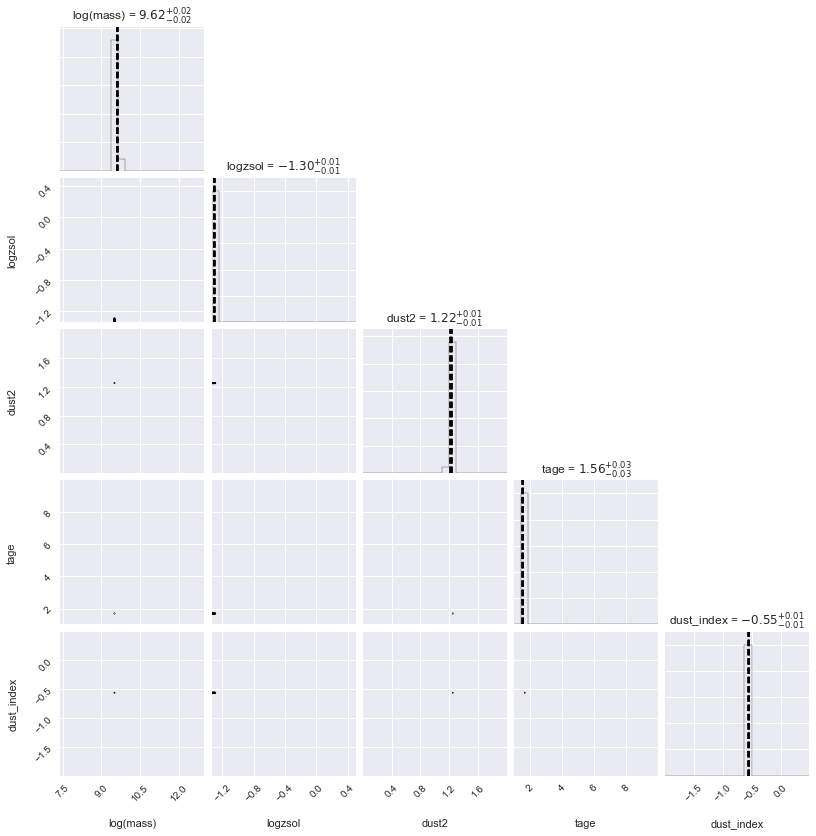

In [196]:
fig = pread.subcorner(respower)
fig.savefig('/Users/sidneylower/Documents/attenuation_runs/powerlaw_corner.png', dpi=300, bbox_inches='tight')

In [55]:
imaxp = np.argmax(respower['lnprobability'])
imaxC = np.argmax(resCal['lnprobability'])
imaxM = np.argmax(resMW['lnprobability'])
imaxK = np.argmax(resKC['lnprobability'])
theta_bestp = respower['chain'][imaxp, :].copy()
theta_bestC = resCal['chain'][imaxC, :].copy()
theta_bestM = resMW['chain'][imaxM, :].copy()
theta_bestK = resKC['chain'][imaxK, :].copy()

#thetas = [theta_bestC, theta_bestK, theta_bestM, theta_bestp]

time = 2.0*u.Gyr
sfrs = []


sps = build_sps()
mod = build_model()
spec, phot, mfracp = mod.mean_model(theta_bestp, obspower, sps)
spec, phot, mfracC = modCal.mean_model(theta_bestC, obsCal, sps)
spec, phot, mfracM = mod.mean_model(theta_bestM, obsMW, sps)
spec, phot, mfracK = mod.mean_model(theta_bestK, obsKC, sps)





In [6]:
#mKC = [item[0] for item in resKC['chain']]
mCal = [item[0] for item in resCal['chain']]
mMW = [item[0]  for item in resMW['chain']]

mpower = [item[0]  for item in respower['chain']]

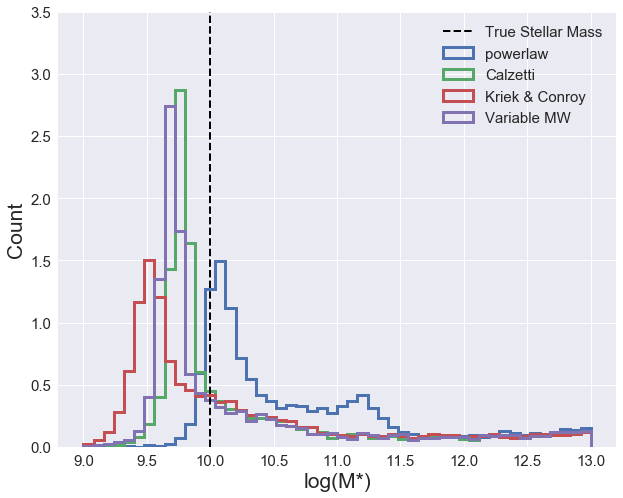

In [69]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(np.log10(mpower), bins=50, range=(9., 13), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(np.log10(mCal), bins=50, range=(9., 13), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(np.log10(mKC), bins=50, range=(9., 13), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(np.log10(mMW), bins=50, range=(9., 13), lw=3,histtype='step', density=True, label='Variable MW')
plt.plot([10.0, 10.0], [0, 35], ls='--', lw=2, color='black', label = 'True Stellar Mass')

plt.xlabel('log(M*)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 3.5])
plt.legend(loc='best', fontsize=15)


plt.savefig('/Users/sidneylower/Documents/atten_mass_inputPL.png', dpi=300)

In [90]:
zpower = [item[1] for item in respower['chain']]
#zKC = [item[1] for item in resKC['chain']]
zCal = [item[1] for item in resCal['chain']]
zMW = [item[1] for item in resMW['chain']]

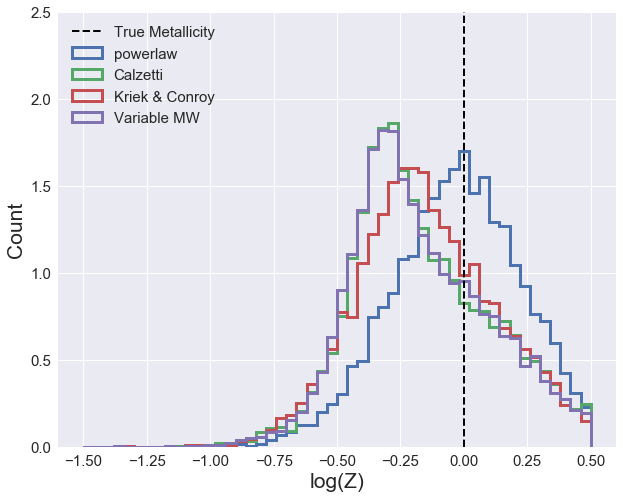

In [75]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(zpower, bins=50, range=(-1.5, 0.5), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(zCal, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(zKC, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(zMW, bins=50, range=(-1.5, 0.5), lw=3,histtype='step', density=True, label='Variable MW')
plt.plot([0.0, 0.0], [0, 35], ls='--', lw=2, color='black', label = 'True Metallicity')

plt.xlabel('log(Z)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0,2.5])
plt.legend(loc='upper left', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_metal_inputPL.png', dpi=300)

In [7]:
agepower = [item[3] for item in respower['chain']]
#ageKC = [item[3] for item in resKC['chain']]
ageCal = [item[3] for item in resCal['chain']]
ageMW = [item[3] for item in resMW['chain']]


true_age = 2.0

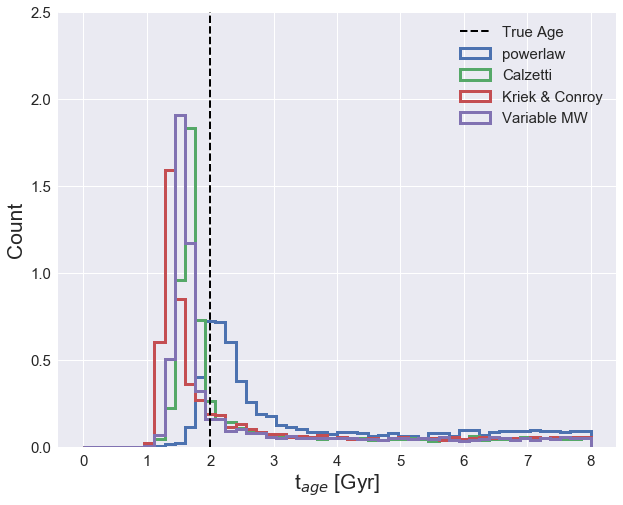

In [76]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(agepower, bins=50, range=(0, 8), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(ageCal, bins=50, range=(0, 8), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(ageKC, bins=50, range=(0, 8), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(ageMW, bins=50, range=(0, 8), lw=3,histtype='step', density=True, label='Variable MW')
plt.plot([true_age, true_age], [0, 35], ls='--', lw=2, color='black', label = 'True Age')

plt.xlabel('t$_{age}$ [Gyr]', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0, 2.5])
plt.legend(loc='upper right', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_age_inputPL.png', dpi=300)

In [9]:
true_sfr = np.log10((1e10 / (true_age*1.e9)) * (true_age) *np.exp(-(true_age) / 1.0))
print(true_sfr)

0.13141103619349637


In [15]:
#mass_distrs = [mpower, mKC, mCal, mMW]
#age_distrs = [agepower, ageKC, ageCal, ageMW]
#tau_distrs = [taupower, tauKC, tauCal, tauMW]

#time = 1.0

sfrpower = []
sfrKC = []
sfrCal = []
sfrMW = []
for i in range(len(mpower)):
    sfrpower.append(np.log10((mpower[i] / (agepower[i]*1.e9)) * (3-agepower[i]) *np.exp(-(3-agepower[i]) / 1.0)))

#for i in range(len(mKC)):
#    sfrKC.append(np.log10((mKC[i] / (ageKC[i]*1.e9)) * (3.0 - ageKC[i]) *np.exp(-(3.0 - ageKC[i]) / 1.0)))
for i in range(len(mCal)):
    sfrCal.append(np.log10((mCal[i] / (ageCal[i]*1.e9)) * (3-ageCal[i]) *np.exp(-(3-ageCal[i]) / 1.0)))
for i in range(len(mMW)):
    sfrMW.append(np.log10((mMW[i] / (ageMW[i]*1.e9)) * (3-ageMW[i]) *np.exp(-(3-ageMW[i]) / 1.0)))


/Users/sidneylower/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


/Users/sidneylower/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/sidneylower/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


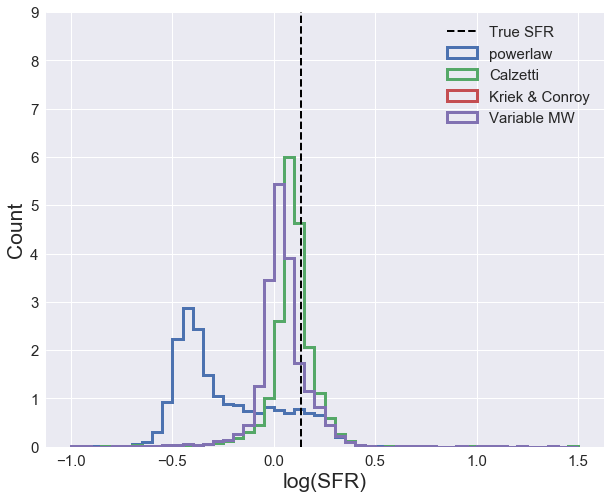

In [16]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
labels = ['powerlaw', 'Kriek & Conroy', 'Calzetti', 'MW']
n, bins, _ = plt.hist(sfrpower, bins=50, range=(-1, 1.5), lw=3, histtype='step', density=True, label='powerlaw')
n, bins, _ = plt.hist(sfrCal, bins=50, range=(-1, 1.5), lw=3,histtype='step', density=True, label='Calzetti')
n, bins, _ = plt.hist(sfrKC, bins=50, range=(-1, 1.5), lw=3,histtype='step', density=True, label='Kriek & Conroy')
n, bins, _ = plt.hist(sfrMW, bins=50, range=(-1, 1.5), lw=3,histtype='step', density=True, label='Variable MW')

plt.plot([true_sfr, true_sfr], [0, 35], ls='--', lw=2, color='black', label = 'True SFR')

plt.xlabel('log(SFR)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([0,9])
plt.legend(loc='upper right', fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/atten_sfr_inputPL.png', dpi=300)

In [93]:
calzetti = [mCal, zCal, ageCal, sfrCal]
cardelli = [mMW, zMW, ageMW, sfrMW]
#kriek_conroy = [mKC, zKC, ageKC, sfrKC]
powerlaw = [mpower, zpower, agepower, sfrpower]
keys = ['mass', 'log(metallicity)', 'age', 'log(sfr)']

In [94]:
mass_dict = {}
mass_dict['calzetti'] = calzetti[0]
mass_dict['cardelli'] = cardelli[0]
#mass_dict['kriek_conroy'] = kriek_conroy[0]
mass_dict['smc'] = powerlaw[0]

In [95]:
metal_dict = {}
metal_dict['calzetti'] = calzetti[1]
metal_dict['cardelli'] = cardelli[1]
#metal_dict['kriek_conroy'] = kriek_conroy[1]
metal_dict['smc'] = powerlaw[1]

In [96]:
age_dict = {}
age_dict['calzetti'] = calzetti[2]
age_dict['cardelli'] = cardelli[2]
#age_dict['kriek_conroy'] = kriek_conroy[2]
age_dict['smc'] = powerlaw[2]

In [97]:
sfr_dict = {}
sfr_dict['calzetti'] = calzetti[3]
sfr_dict['cardelli'] = cardelli[3]
#sfr_dict['kriek_conroy'] = kriek_conroy[3]
sfr_dict['smc'] = powerlaw[3]

In [98]:
full_dict = {}
full_dict['mass'] = mass_dict
full_dict['metallicity'] = metal_dict
full_dict['age'] = age_dict
full_dict['log(sfr)'] = sfr_dict

In [99]:
np.savez('/Users/sidneylower/Documents/attenuation_tests_inputPL_fixed.npz', **full_dict)

In [3]:
import prospect.io.read_results as pread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec

In [2]:
ultra = pd.read_pickle('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/snap305_ultra/reparam_noll/prospectorsnap305_properties_Dirichlet_1570543762.1712768.pkl')

In [3]:
true_mass1 = list(dict.fromkeys(ultra.loc[['300']]['Intrinsic Stellar Mass']))[0] / 1.989e33
#true_mass2 = list(dict.fromkeys(ultra.loc[['052']]['Intrinsic Stellar Mass']))[0] / 1.989e33

In [4]:
res1, obs, mod = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/SMC/snap305_galaxy300_smc.h5')

In [5]:
res2, obs, mod = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/calzetti/snap305_galaxy300_calzetti.h5')

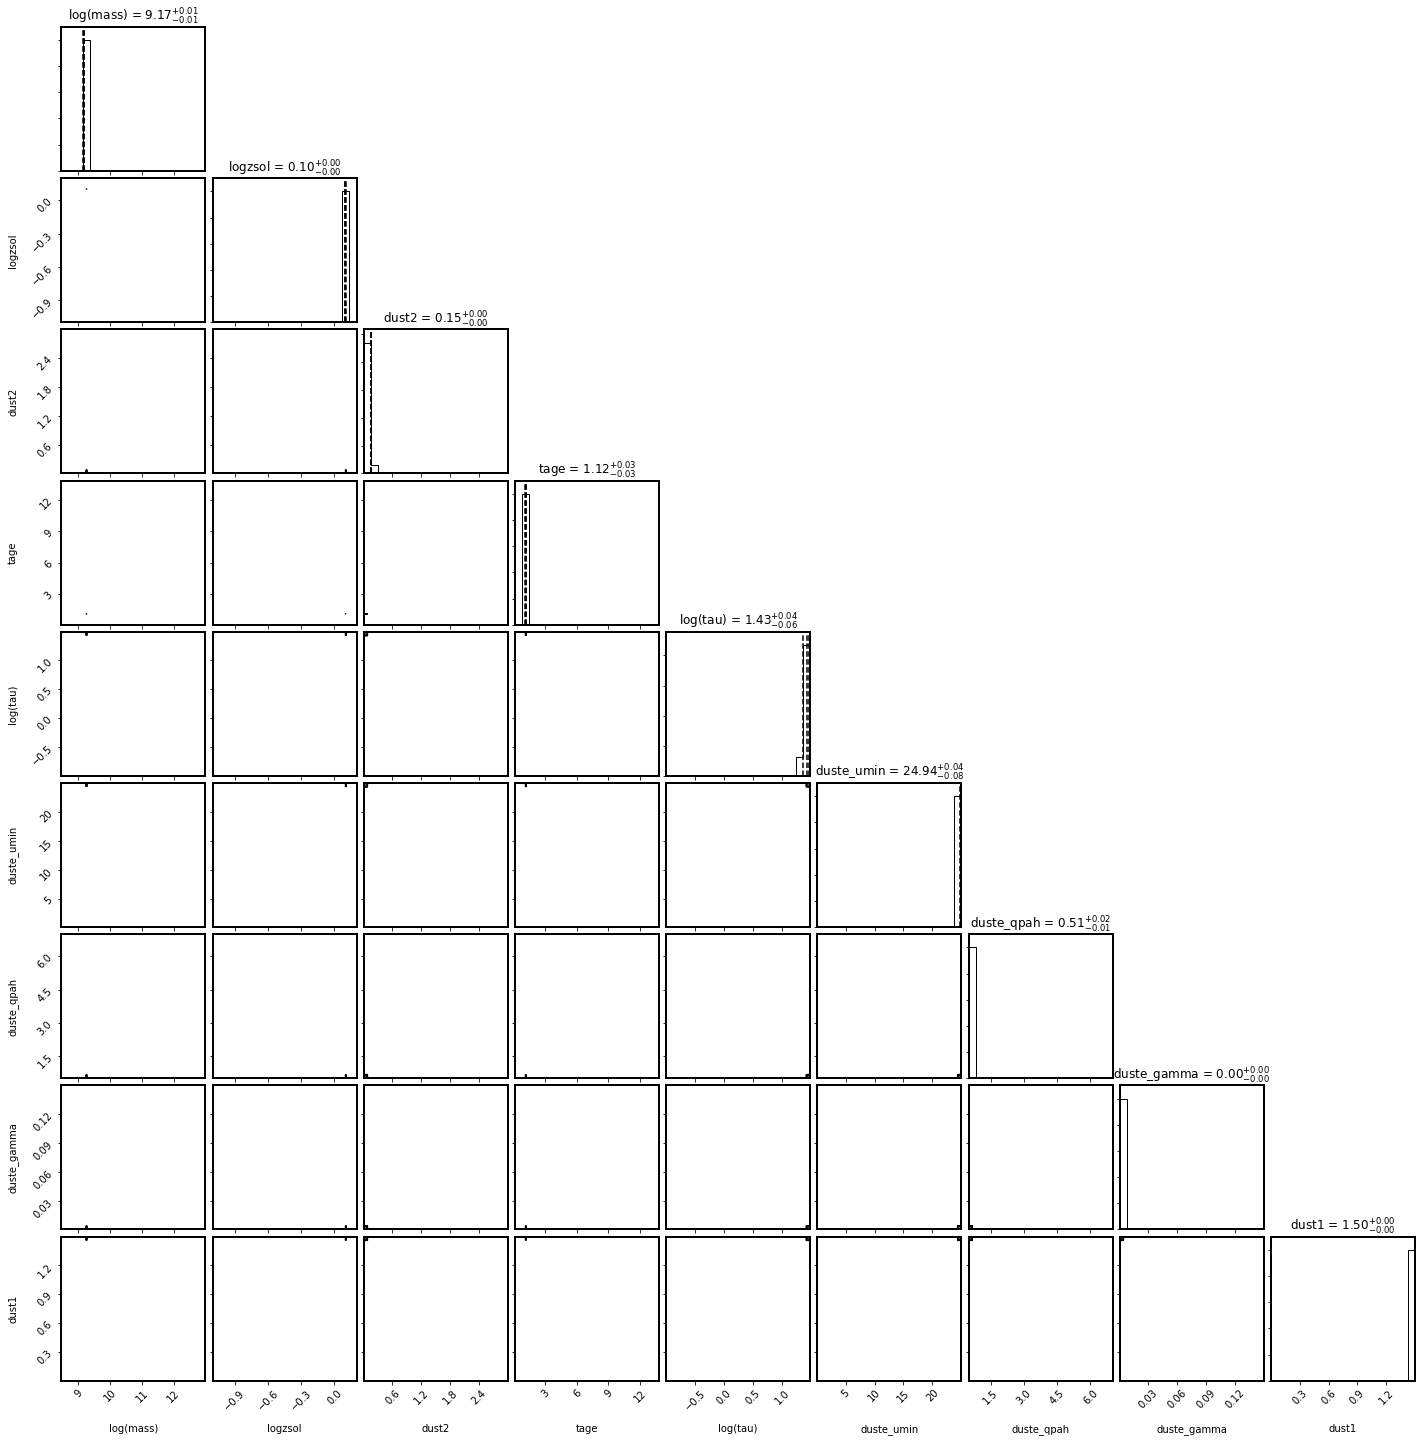

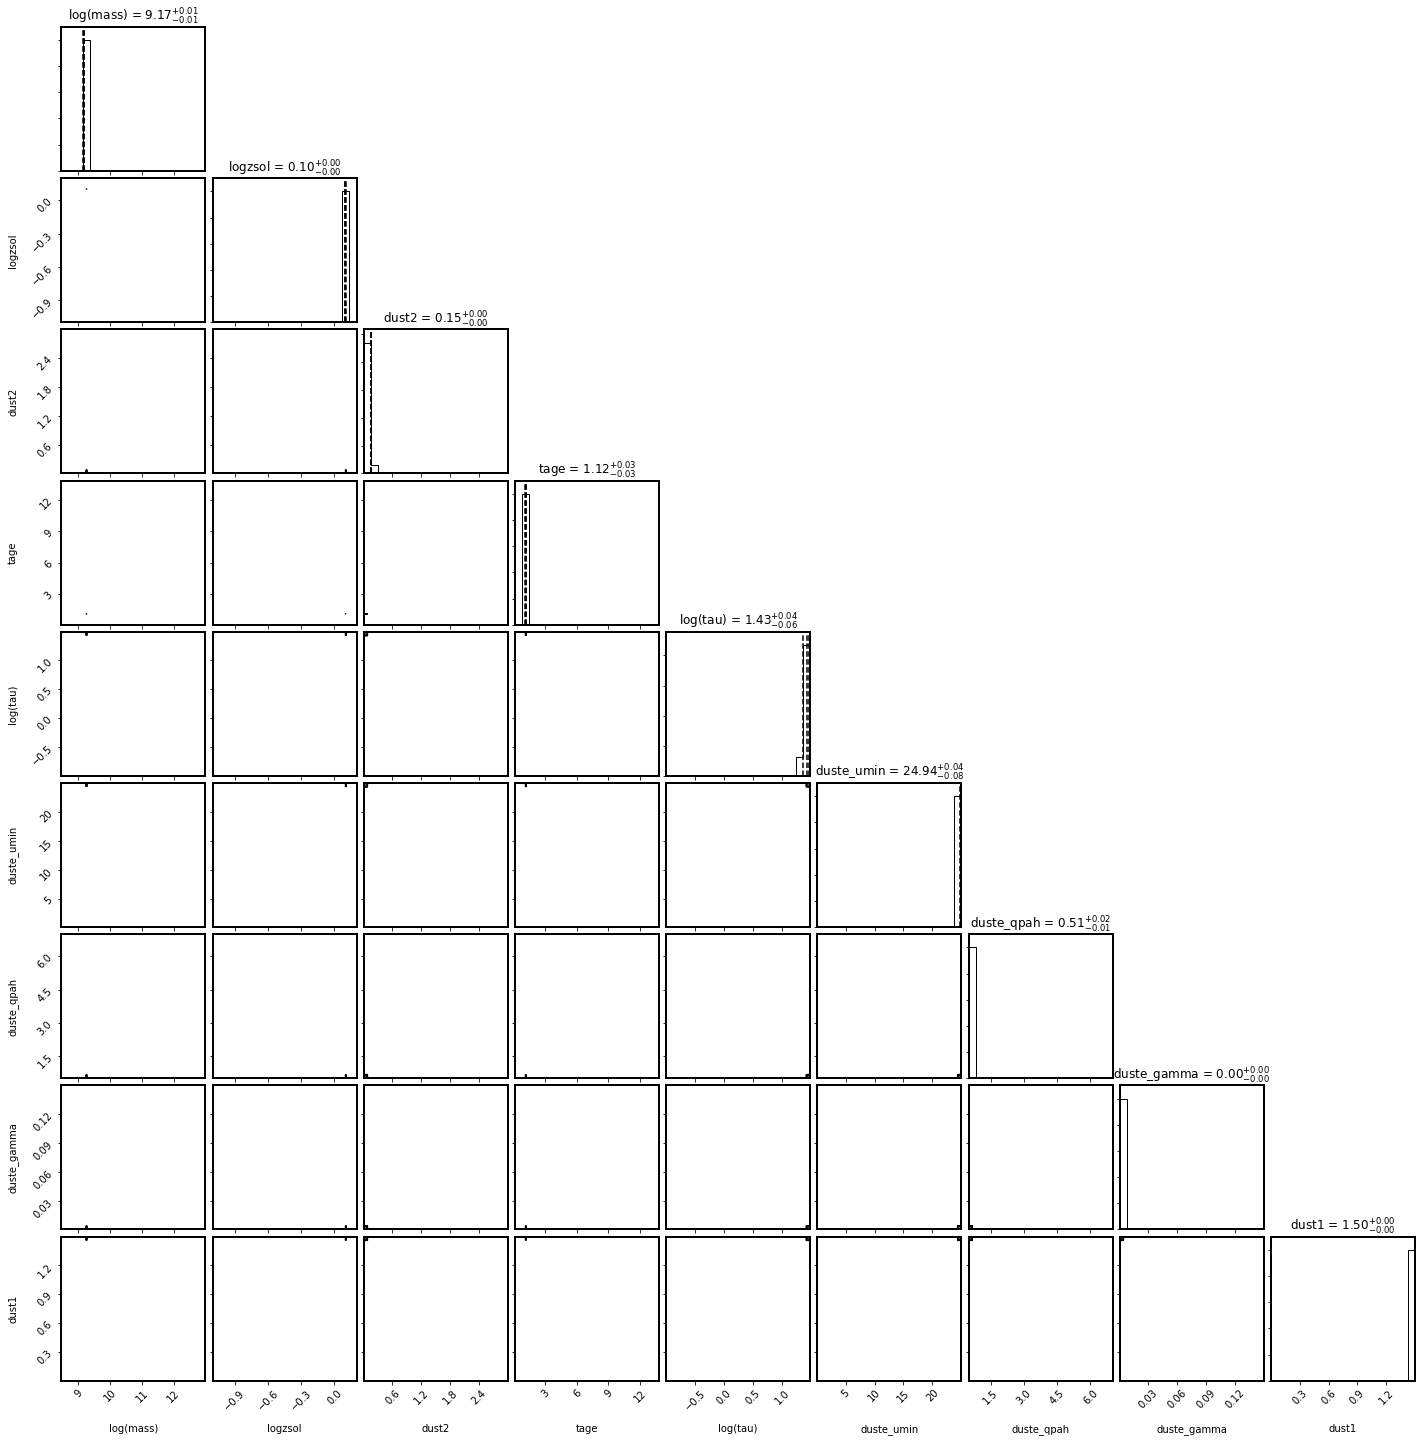

In [80]:
pread.subcorner(res1)

In [6]:
msimba1 = [item[0] for item in res1['chain']]
msimba2 = [item[0] for item in res2['chain']]

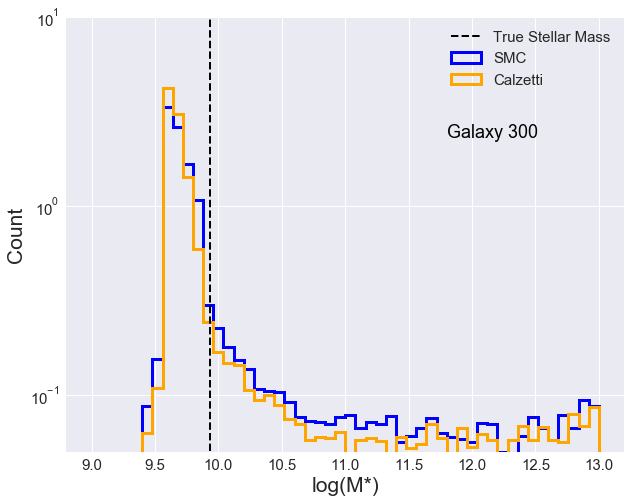

In [49]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(np.log10(msimba1), bins=50, range=(9., 13), lw=3, histtype='step', color='blue', density=True, label='SMC')
plt.plot([np.log10(true_mass1), np.log10(true_mass1)], [0, 35], ls='--', lw=2, color='black', label = 'True Stellar Mass')

n, bins, _ = plt.hist(np.log10(msimba2), bins=50, range=(9., 13), lw=3, histtype='step', color='orange', density=True, label='Calzetti')


plt.yscale('log')
plt.xlabel('log(M*)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([5e-2, 1e1])
plt.legend(loc='best', fontsize=15)


#plt.annotate('Galaxy 52', xy=(11.8, 2.3), color='darkorange', fontsize=18)
plt.annotate('Galaxy 300', xy=(11.8, 2.3), color='Black', fontsize=18)

plt.savefig('/Users/sidneylower/Documents/atten_mass_simba.png', dpi=300)

In [8]:
metals = np.load('/Users/sidneylower/Documents/snap305_dirichlet/snap305_massweightedZ.npz')['Z_massweighted']
solar = 0.0196

In [9]:
true_Z1 = np.log10(metals[300] / solar)


In [10]:
Zsimba1 = [item[1] for item in res1['chain']]
Zsimba2 = [item[1] for item in res2['chain']]

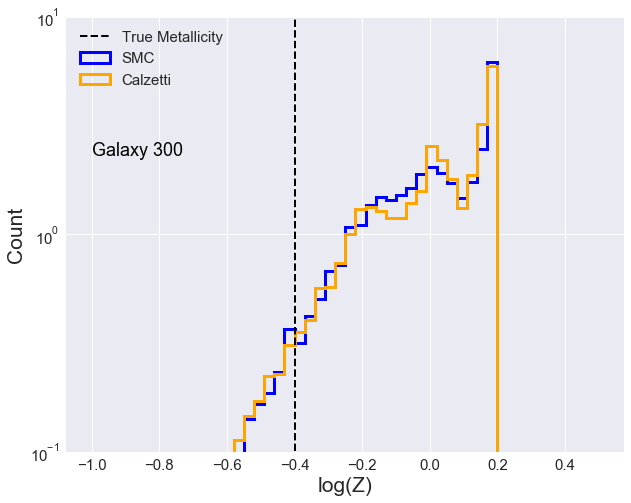

In [13]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(Zsimba1, bins=50, range=(-1., 0.5), lw=3, color='blue', histtype='step', density=True, label='SMC')
n, bins, _ = plt.hist(Zsimba2, bins=50, range=(-1., 0.5), lw=3,histtype='step', color='orange', density=True, label='Calzetti')
#plt.plot([0.0, 0.0], [0, 35], ls='--', lw=2, color='black', label = 'True Metallicity')
plt.plot([true_Z1 ,true_Z1], [0, 35], ls='--', lw=2, color='black', label = 'True Metallicity')



plt.annotate('Galaxy 300', xy=(-1, 2.3), color='black', fontsize=18)

plt.yscale('log')
plt.xlabel('log(Z)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([1e-1, 1e1])
plt.legend(loc='upper left', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_metal_simba.png', dpi=300)

In [14]:
tausimba1 = [item[4] for item in res1['chain']]
tausimba2 = [item[4] for item in res2['chain']]

agesimba1 = [item[3] for item in res1['chain']]
agesimba2 = [item[3] for item in res2['chain']]

In [18]:
sfr1 = []
sfr2 = []

for i in range(len(msimba1)):
    sfr1.append(np.log10((msimba1[i] / (agesimba1[i]*1.e9)) * (13.8-agesimba1[i]) *np.exp(-(13.8-agesimba1[i]) / tausimba1[i])))
    
for i in range(len(msimba2)):
    sfr2.append(np.log10((msimba2[i] / (agesimba2[i]*1.e9)) * (13.8-agesimba2[i]) *np.exp(-(13.8-agesimba2[i]) / tausimba2[i])))
    
    

In [20]:
caesar_sfr50 = np.load('/Users/sidneylower/Documents/snap305_dirichlet/caesar_sfr50.npz')


In [38]:
true_sfr = np.log10(caesar_sfr50['sfr_50'][300])

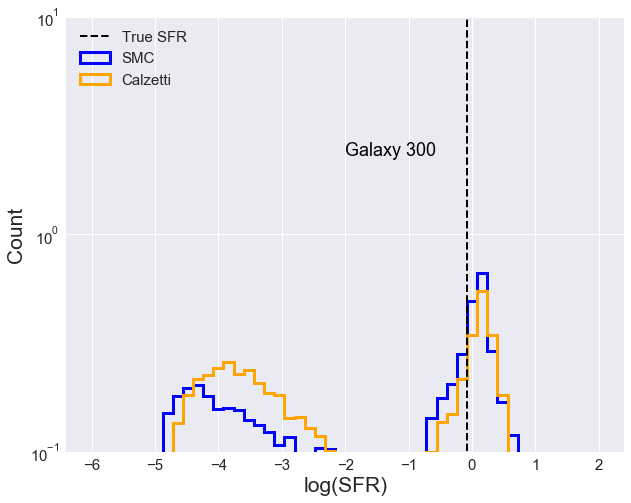

In [51]:
plt.figure(figsize=(10, 8))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
n, bins, _ = plt.hist(sfr1, bins=50, range=(-6., 2.0), lw=3, color='blue', histtype='step', density=True, label='SMC')
n, bins, _ = plt.hist(sfr2, bins=50, range=(-6., 2.0), lw=3,histtype='step', color='orange', density=True, label='Calzetti')
plt.plot([true_sfr ,true_sfr], [0, 35], ls='--', lw=2, color='black', label = 'True SFR')



plt.annotate('Galaxy 300', xy=(-2, 2.3), color='black', fontsize=18)

plt.yscale('log')
plt.xlabel('log(SFR)', fontsize=21)
plt.ylabel('Count', fontsize=21)
plt.ylim([1e-1, 1e1])
plt.legend(loc='upper left', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/atten_sfr_simba.png', dpi=300)

In [41]:
sfr_dict = {}
sfr_dict['calzetti'] = sfr2
sfr_dict['SMC'] = sfr1

Z_dict = {}
Z_dict['calzetti'] = Zsimba2
Z_dict['SMC'] = Zsimba1

mass_dict = {}
mass_dict['calzetti'] = msimba2
mass_dict['SMC'] = msimba1


true_dict = {}
true_dict['mass'] = true_mass1
true_dict['log(sfr)'] = true_sfr
true_dict['log(metallicity)'] = true_Z1

In [43]:
full_dict = {}
full_dict['mass'] = mass_dict
full_dict['log(metallicity)'] = Z_dict
full_dict['log(sfr)'] = sfr_dict
full_dict['true_values'] = true_dict

In [47]:
np.savez('/Users/sidneylower/Documents/attenuation_tests_simba.npz', **full_dict)

In [4]:
dat = pd.read_pickle('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/simba_bestfit_freedust1.pkl')
dat_nodust = pd.read_pickle('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/simba_bestfit_freedust0.pkl')

In [5]:
smc_mass = dat['mass_smc']
cal_mass = dat['mass_calzetti']
true_mass = dat['true_mass']


smc_mass1 = dat_nodust['mass_smc']
cal_mass1 = dat_nodust['mass_calzetti']
true_mass1 = dat_nodust['true_mass']

[]

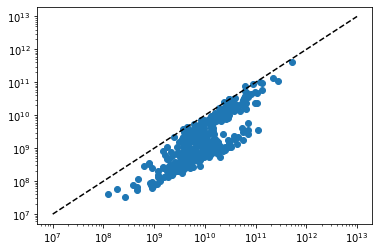

In [13]:
plt.scatter(true_mass, smc_mass)
#plt.scatter(true_mass, cal_mass)
plt.plot([1e7, 1e13], [1e7, 1e13], color='black', ls='--')
plt.loglog()

[]

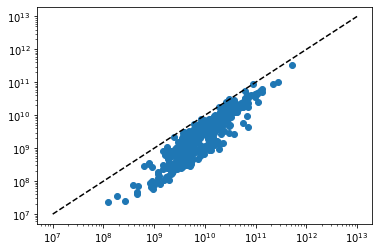

In [14]:
plt.scatter(true_mass, cal_mass)
#plt.scatter(true_mass, cal_mass)
plt.plot([1e7, 1e13], [1e7, 1e13], color='black', ls='--')
plt.loglog()

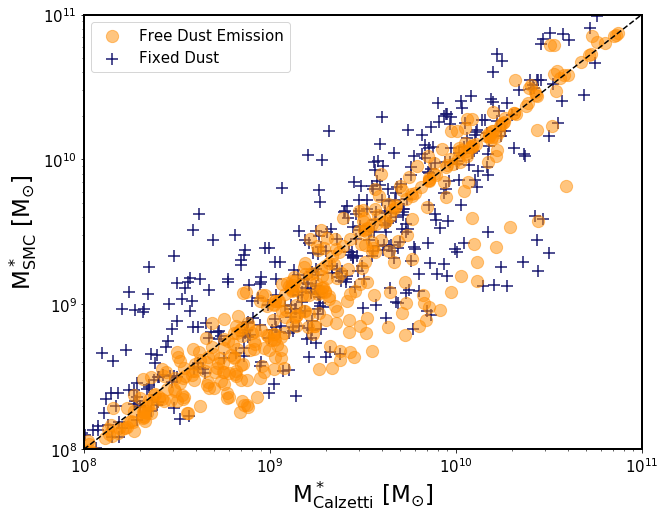

In [38]:
plt.figure(figsize=(10, 8))
#plt.style.use('seaborn')
plt.rc('axes', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')
plt.scatter(cal_mass, smc_mass, s=150,color='darkorange' , alpha=0.5, label='Free Dust Emission')
plt.scatter(cal_mass1, smc_mass1, s=150, zorder=0, color='midnightblue', marker='+', label='Fixed Dust')
#plt.scatter(true_mass, cal_mass)
plt.plot([1e8, 1e11], [1e8, 1e11], color='black', ls='--')
plt.loglog()
plt.ylabel('M$^*_\mathrm{SMC}$ [M$_{\odot}$]', fontsize=23)
plt.xlabel('M$^*_\mathrm{Calzetti}$ [M$_{\odot}$]', fontsize=23)
plt.ylim([1e8, 1e11])
plt.xlim([1e8, 1e11])
plt.legend(loc='best', fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/mass.png', dpi=300, bbox_inches='tight')

In [36]:
len(smc_mass1)

453

In [16]:
smc_sfr1 = dat['log(sfr)_smc']
cal_sfr1 = dat['log(sfr)_cal']

smc_sfr2 = dat_nodust['log(sfr)_smc']
cal_sfr2 = dat_nodust['log(sfr)_cal']

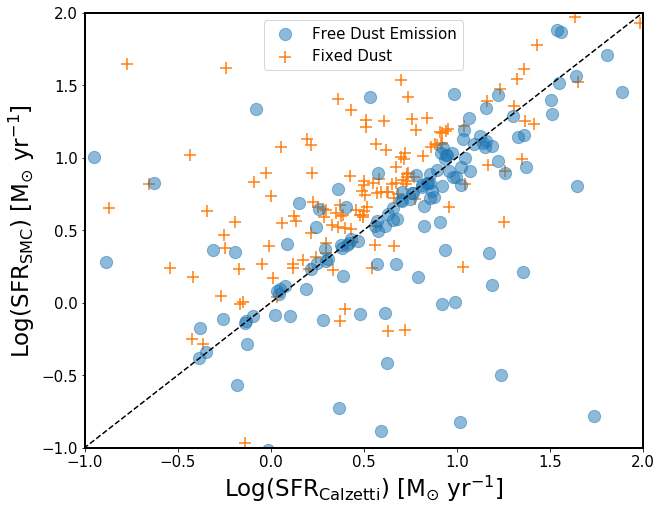

In [20]:
plt.figure(figsize=(10, 8))
#plt.style.use('seaborn')
plt.rc('axes', linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor')

plt.scatter(np.log10(cal_sfr1), np.log10(smc_sfr1), s=150, alpha=0.5, label='Free Dust Emission')
plt.scatter(np.log10(cal_sfr2), np.log10(smc_sfr2),s=150, zorder=0, marker='+', label='Fixed Dust')
#plt.scatter(true_mass, cal_mass)
plt.plot([-11, 10], [-11, 10], color='black', ls='--')
plt.xlim([-1, 2])
plt.ylim([-1, 2])

plt.ylabel('Log(SFR$_\mathrm{SMC}$) [M$_{\odot}$ yr$^{-1}$]', fontsize=23)
plt.xlabel('Log(SFR$_\mathrm{Calzetti}$) [M$_{\odot}$ yr$^{-1}$]', fontsize=23)
plt.legend(loc='best', fontsize=15)
plt.savefig('/Users/sidneylower/Documents/sfr.png', dpi=300, bbox_inches='tight')

In [21]:
res1, obs1, mod1 = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/SMC/snap305_galaxy300_smc.h5')
res2, obs2, mod2 = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/SMC/fixed_dust/snap305_galaxy300_smc.h5')


res3, obs3, mod3 = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/calzetti/snap305_galaxy300_Calzetti.h5')
res4, obs4, mod4 = pread.results_from('/Volumes/ufrc/narayanan/s.lower/atten_test/simba_runs/calzetti/fixed_dust/snap305_galaxy300_Calzetti.h5')

In [22]:
def build_model1(mod, **kwargs):

    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel


    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    #fixed delayed-tau SFH                                                                                 
    model_params['tau']['isfree'] = True
    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=0.0, maxi=13.8)
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.ClippedNormal(mini=-1.8, maxi=0.2, mean=0.0, sigma=0.3)     \


    #dust emission                                                                                         
    model_params['duste_gamma']['isfree'] = True
    model_params['duste_qpah']['isfree'] = True
    model_params['duste_umin']['isfree'] = True
    model_params = model_library(model_params, 1, True)
    

    model = sedmodel.SedModel(model_params)


    return model

In [31]:
def build_model2(mod, **kwargs):

    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel


    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    #fixed delayed-tau SFH                                                                                 
    model_params['tau']['isfree'] = True
    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=0.0, maxi=13.8)
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.ClippedNormal(mini=-1.8, maxi=0.2, mean=0.0, sigma=0.3)     \


    #dust emission                                                                                         
    model_params['duste_gamma']['isfree'] = False
    model_params['duste_qpah']['isfree'] = False
    model_params['duste_umin']['isfree'] = False
    model_params = model_library(model_params, 1, True)
    

    model = sedmodel.SedModel(model_params)


    return model

In [24]:
def build_model3(mod, **kwargs):

    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel


    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    #fixed delayed-tau SFH                                                                                 
    model_params['tau']['isfree'] = True
    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=0.0, maxi=13.8)
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.ClippedNormal(mini=-1.8, maxi=0.2, mean=0.0, sigma=0.3)     \


    #dust emission                                                                                         
    model_params['duste_gamma']['isfree'] = True
    model_params['duste_qpah']['isfree'] = True
    model_params['duste_umin']['isfree'] = True
    model_params = model_library(model_params, 2, False)
    

    model = sedmodel.SedModel(model_params)


    return model

In [25]:
def build_model4(mod, **kwargs):

    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel


    model_params = TemplateLibrary["parametric_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    #fixed delayed-tau SFH                                                                                 
    model_params['tau']['isfree'] = True
    model_params["lumdist"] = {"N": 1, "isfree": False,
                         "init": 1.0e-5, "units": "Mpc"}
    model_params['tage']['prior'] = priors.TopHat(mini=0.0, maxi=13.8)
    model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
    model_params['logzsol']['isfree'] = True
    model_params['logzsol']['prior'] = priors.ClippedNormal(mini=-1.8, maxi=0.2, mean=0.0, sigma=0.3)     \


    #dust emission                                                                                         
    model_params['duste_gamma']['isfree'] = False
    model_params['duste_qpah']['isfree'] = False
    model_params['duste_umin']['isfree'] = False
    model_params = model_library(model_params, 2, False)
    

    model = sedmodel.SedModel(model_params)


    return model

In [26]:
def model_library(model_params, attenuation_model, dust1=False):

    from prospect.models import priors
    if attenuation_model == 0:
        name = 'MW_fixed'
        model_params["dust_type"] = {"N": 1, "isfree": False, "init": 1, "units": name}
        model_params["mrw"] = {"N": 1, "isfree": False,
                           "init": 3.1, "units": "The ratio of total to selective absorption which characterizes the MW\
 extinction curve", 'prior' : priors.TopHat(mini=2.0, maxi=5.0)}
        model_params['uvb'] = {'N': 1, 'isfree': False,
                           'init': 1.0, 'units':"characterizing the strength of the 2175A extinction feature with respe\
ct to the standard Cardelli et al. determination for the MW",
                           'prior': priors.TopHat(mini = 0.1, maxi=3.0)}
        model_params["dust1"]  = {"N": 1, "isfree": dust1,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}

    elif attenuation_model == 1:
        name = 'SMC'
        model_params["dust_type"] = {"N": 1, "isfree": False, "init": 0, "units": name} #power-law                      
        model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=3.0)
        model_params["dust1"]  = {"N": 1, "isfree": dust1,
                     "init": 0.0, "prior" : priors.TopHat(mini=0.0, maxi=1.5),
                     "units": "optical depth towards young stars"}
        model_params["dust_index"] = {"N": 1, "isfree": False,
                     "init": -1.19, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}
        model_params["dust_index1"] = {"N": 1, "isfree": False,
                     "init": -1.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.0, maxi=0.5)}


    elif attenuation_model == 2:
        name = 'Calzetti_fixed'
        model_params["dust_type"] = {"N": 1, "isfree": False, "init": 2, "units": name} #Calzetti                       
        model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=3.0)
        model_params["dust1"] = {"N": 1, "isfree": False,
                         "init": 0.0, "units": "optical depth towards young stars"}

    return model_params

In [27]:
def build_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps

In [28]:
def get_best(res, mod, **kwargs):
    """Get the maximum a posteriori parameters.                                                                         
    From prospect.utils.plotting                                                                                        
    """
    imax = np.argmax(res['lnprobability'])
    # there must be a more elegant way to deal with differnt shapes                                                     
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta_best = res['chain'][i, j, :].copy()
    except(ValueError):
        theta_best = res['chain'][imax, :].copy()

    theta_names = res.get('theta_labels', mod.theta_labels())
    return theta_names, theta_best

In [32]:
sps = build_sps()
mod1 = build_model1(1)
mod2 = build_model2(1)
mod3 = build_model3(2)
mod4 = build_model4(2)

In [33]:
thetas, best1 = get_best(res1, mod1)
th2, best2 = get_best(res2, mod2)
best3 = get_best(res3, mod3)[1]
best4 = get_best(res4, mod4)[1]


phot_wavelengths1 = [x.wave_mean for x in obs1['filters']]
phot_wavelengths2 = [x.wave_mean for x in obs2['filters']]
spec_wavelengths = sps.wavelengths

spec1, phot1, massfrac1 = mod1.mean_model(best1, obs1, sps=sps)
spec2, phot2, massfrac2 = mod2.mean_model(best2, obs2, sps=sps)
spec3, phot3, massfrac3 = mod3.mean_model(best3, obs3, sps=sps)
spec4, phot4, massfrac4 = mod4.mean_model(best4, obs4, sps=sps)

In [ ]:
gal = 300

In [ ]:
observed = '/Volumes/ufrc/narayanan/s.lower/SEDs/z0/SED_galaxy'+str(gal)+'.npz'
obs = np.load(observed)
obs_spec = obs['spec']
obs_wav = obs['wav']

In [73]:
residuals1 = phot1 / obs1['maggies']
residuals2 = phot2 / obs2['maggies']

residuals3 = phot3 / obs3['maggies']
residuals4 = phot4 / obs4['maggies']

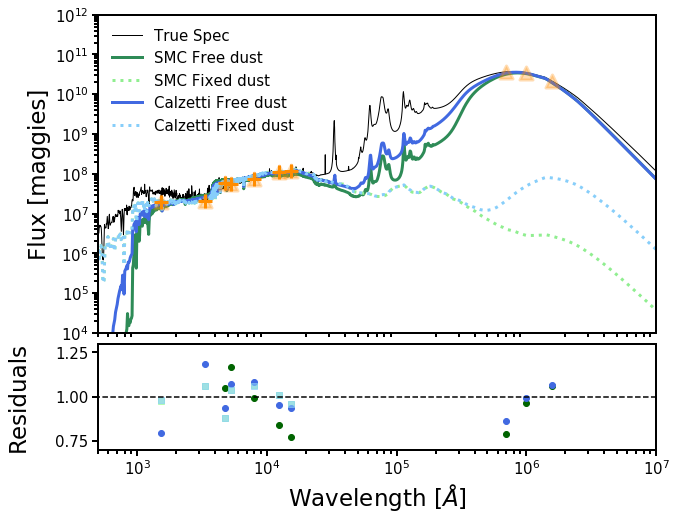

In [79]:
plt.rc('axes', linewidth=2)
fig = plt.figure(figsize=(10, 8)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplots_adjust(wspace=0.04, hspace=0.05)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for ax in [ax0, ax1]:
    ax.set_xlim([5e2, 1e7])
    ax.tick_params(axis='both', which='major', width=2, length=6, labelsize=15)
    ax.tick_params(axis='both', which='minor', width=2, length=4)


ax0.scatter(phot_wavelengths2, obs2['maggies'], color='darkorange', s=170, marker='+', lw=3, zorder=10)

ax0.scatter(phot_wavelengths1, obs1['maggies'], color='darkorange', s=170, marker='^', alpha=0.3, lw=3, zorder=9)
ax0.plot(obs_wav, obs_spec, color='black', lw=1, label='True Spec')

ax0.plot(spec_wavelengths*(1.+0.01), spec1, color='seagreen' ,  lw=3, label='SMC Free dust')
ax0.plot(spec_wavelengths*(1.+0.01), spec2, color='lightgreen' , ls=':', lw=3, label='SMC Fixed dust')
ax0.plot(spec_wavelengths*(1.+0.01), spec3, color='royalblue' ,  lw=3, label='Calzetti Free dust')
ax0.plot(spec_wavelengths*(1.+0.01), spec4, color='lightskyblue' , ls=':', lw=3, label='Calzetti Fixed dust')

ax0.loglog()
ax0.set_ylim([1e4, 1e12])
ax0.set_ylabel('Flux [maggies]', fontsize=23)
ax0.set_xlabel('Wavelength [$\AA$]', fontsize=23)
ax0.get_xaxis().set_ticks([])

ax1.scatter(phot_wavelengths1, residuals1, color = 'darkgreen', marker='o')
ax1.scatter(phot_wavelengths2, residuals2, color = 'palegreen', marker='s', alpha=0.6)
ax1.scatter(phot_wavelengths1, residuals3, color='royalblue', marker='o')
ax1.scatter(phot_wavelengths2, residuals4, color='lightskyblue', marker='s', alpha=0.6)
ax1.plot([1e2, 1e8], [1.0,1.0], color='black', ls='--')
ax1.set_xscale('log')
ax1.set_ylim([0.7, 1.3])
ax1.set_ylabel('Residuals', fontsize=23, labelpad=25)
ax1.set_xlabel('Wavelength [$\AA$]', fontsize=23)


#ax0.annotate('Galaxy '+str(gal)+'\nM* ='+"{:.2e}".format(true_mass[gal])+' M$_{\odot}$',xy=(1e5, 1e-6), fontsize=20)
ax0.legend(loc='upper left', fontsize=15, frameon=False)

#plt.tight_layout()
plt.savefig('/Users/sidneylower/Documents/SED_'+str(gal)+'_allmodels.png', dpi=300, bbox_inches='tight')

In [1]:
"{:03d}".format(10)

'010'